In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import preprocessing
from tensorflow.keras.preprocessing import image_dataset_from_directory

2022-06-08 20:45:40.616325: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


# Loading SIPI Dataset

SIPI dataset was preprocessed using prepare_dataset notebook, so these three folders already contain Detritus/Non-Detritus images.

In [2]:
DatasetName = 'Dataset-Detritus-Bubble'

In [3]:
train_dir = DatasetName+'/train'
validation_dir =  DatasetName+'/val'
test_dir = DatasetName+'/test'

In [4]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)

The three datasets are loaded using keras preprocessing method *image_dataset_from_directory*. Both the batch size and the image size hyperparameters where tested using different values. 

In [5]:
train_dataset = image_dataset_from_directory(train_dir,
shuffle=True,
batch_size=BATCH_SIZE,
image_size=IMG_SIZE)

validation_dataset = image_dataset_from_directory(validation_dir,
shuffle=True,
batch_size=BATCH_SIZE,
image_size=IMG_SIZE)

test_dataset = image_dataset_from_directory(test_dir,
shuffle=True,
batch_size=BATCH_SIZE,
image_size=IMG_SIZE)

Found 38391 files belonging to 2 classes.


2022-06-08 20:45:45.941960: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2022-06-08 20:45:45.990730: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:02:00.0 name: NVIDIA GeForce GTX TITAN X computeCapability: 5.2
coreClock: 1.076GHz coreCount: 24 deviceMemorySize: 11.92GiB deviceMemoryBandwidth: 313.37GiB/s
2022-06-08 20:45:45.992699: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 1 with properties: 
pciBusID: 0000:81:00.0 name: NVIDIA GeForce GTX TITAN X computeCapability: 5.2
coreClock: 1.076GHz coreCount: 24 deviceMemorySize: 11.93GiB deviceMemoryBandwidth: 313.37GiB/s
2022-06-08 20:45:45.992758: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2022-06-08 20:45:45.999200: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library

Found 8226 files belonging to 2 classes.
Found 8227 files belonging to 2 classes.


# Data Augmentation

This adds random transformations to the training images in order to reduce overfitting.

In [6]:
data_augmentation = tf.keras.Sequential([
tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

2022-06-08 20:45:47.848124: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-06-08 20:45:47.869073: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 2099915000 Hz


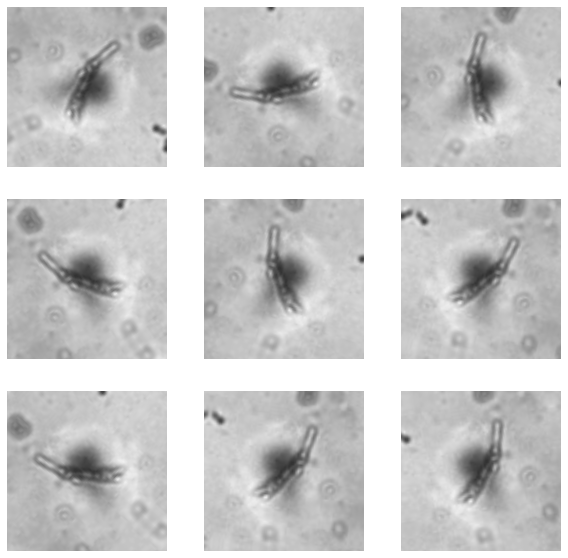

In [7]:
for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
first_image = image[0]
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

# Training

In [8]:
# Hyperparamers to be used in all models
base_learning_rate = 0.0001

In [9]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
dense_base_model = tf.keras.applications.DenseNet201(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

dense_base_model.trainable = False

dense_preprocess_input = tf.keras.applications.densenet.preprocess_input
dense_global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
dense_prediction_layer = tf.keras.layers.Dense(1)

dense_inputs = tf.keras.Input(shape=(160, 160, 3))
dense_x = data_augmentation(dense_inputs)
dense_x = dense_preprocess_input(dense_inputs)
dense_x = dense_base_model(dense_x, training=False)
dense_x = dense_global_average_layer(dense_x)
dense_x = tf.keras.layers.Dropout(0.2)(dense_x)
dense_outputs = dense_prediction_layer(dense_x)
dense_model = tf.keras.Model(dense_inputs, dense_outputs)

2022-06-08 20:45:59.723968: W tensorflow/core/common_runtime/bfc_allocator.cc:456] Allocator (GPU_0_bfc) ran out of memory trying to allocate 288.0KiB (rounded to 294912)requested by op Mul
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2022-06-08 20:45:59.724034: I tensorflow/core/common_runtime/bfc_allocator.cc:991] BFCAllocator dump for GPU_0_bfc
2022-06-08 20:45:59.724061: I tensorflow/core/common_runtime/bfc_allocator.cc:998] Bin (256): 	Total Chunks: 67, Chunks in use: 67. 16.8KiB allocated for chunks. 16.8KiB in use in bin. 2.3KiB client-requested in use in bin.
2022-06-08 20:45:59.724080: I tensorflow/core/common_runtime/bfc_allocator.cc:998] Bin (512): 	Total Chunks: 140, Chunks in use: 140. 74.0KiB allocated for chunks. 74.0KiB in use in bin. 72.5KiB client-requested in use in bin.
2022-06-08 20:45:59.724097: I tensorfl

ResourceExhaustedError: OOM when allocating tensor with shape[1,1,608,128] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:RandomUniform]

In [ ]:
dense_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
dense_model.summary()

In [ ]:
initial_epochs = 20
loss0, accuracy0 = dense_model.evaluate(validation_dataset)

In [13]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.61
initial accuracy: 0.67


In [14]:
dense_history = dense_model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/20
1200/1200 [==============================] - 170s 128ms/step - loss: 0.4471 - accuracy: 0.7655 - val_loss: 0.3767 - val_accuracy: 0.8245
Epoch 2/20
1200/1200 [==============================] - 155s 129ms/step - loss: 0.3709 - accuracy: 0.8200 - val_loss: 0.3473 - val_accuracy: 0.8417
Epoch 3/20
1200/1200 [==============================] - 157s 131ms/step - loss: 0.3513 - accuracy: 0.8319 - val_loss: 0.3344 - val_accuracy: 0.8502
Epoch 4/20
1200/1200 [==============================] - 142s 119ms/step - loss: 0.3401 - accuracy: 0.8413 - val_loss: 0.3271 - val_accuracy: 0.8542
Epoch 5/20
1200/1200 [==============================] - 158s 132ms/step - loss: 0.3352 - accuracy: 0.8454 - val_loss: 0.3222 - val_accuracy: 0.8555
Epoch 6/20
1200/1200 [==============================] - 148s 123ms/step - loss: 0.3308 - accuracy: 0.8483 - val_loss: 0.3202 - val_accuracy: 0.8619
Epoch 7/20
1200/1200 [==============================] - 140s 116ms/step - loss: 0.3299 - accuracy: 0.8483 - val_

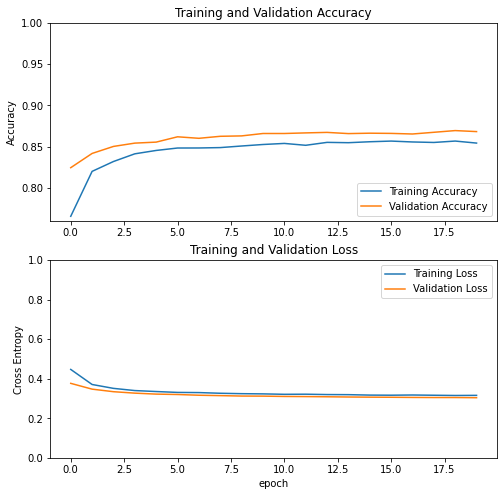

In [15]:
acc = dense_history.history['accuracy']
val_acc = dense_history.history['val_accuracy']

loss = dense_history.history['loss']
val_loss = dense_history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [16]:
dense_base_model.trainable = True

In [17]:

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(dense_base_model.layers))

# Fine-tune from this layer onwards
dense_fine_tune_at = 660

# Freeze all the layers before the `fine_tune_at` layer
for layer in dense_base_model.layers[:dense_fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  707


In [18]:
dense_model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])


In [19]:
len(dense_model.trainable_variables)

41

In [20]:

fine_tune_epochs = 20
total_epochs =  initial_epochs + fine_tune_epochs

dense_history_fine = dense_model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=dense_history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 20/40
1200/1200 [==============================] - 190s 142ms/step - loss: 0.3104 - accuracy: 0.8627 - val_loss: 0.2940 - val_accuracy: 0.8730
Epoch 21/40
1200/1200 [==============================] - 143s 119ms/step - loss: 0.2969 - accuracy: 0.8691 - val_loss: 0.2867 - val_accuracy: 0.8787
Epoch 22/40
1200/1200 [==============================] - 168s 140ms/step - loss: 0.2877 - accuracy: 0.8740 - val_loss: 0.2789 - val_accuracy: 0.8822
Epoch 23/40
1200/1200 [==============================] - 163s 136ms/step - loss: 0.2784 - accuracy: 0.8789 - val_loss: 0.2758 - val_accuracy: 0.8855
Epoch 24/40
1200/1200 [==============================] - 168s 140ms/step - loss: 0.2707 - accuracy: 0.8813 - val_loss: 0.2711 - val_accuracy: 0.8860
Epoch 25/40
1200/1200 [==============================] - 152s 127ms/step - loss: 0.2630 - accuracy: 0.8856 - val_loss: 0.2682 - val_accuracy: 0.8866
Epoch 26/40
1200/1200 [==============================] - 169s 140ms/step - loss: 0.2550 - accuracy: 0.8899

In [21]:

acc += dense_history_fine.history['accuracy']
val_acc += dense_history_fine.history['val_accuracy']

loss += dense_history_fine.history['loss']
val_loss += dense_history_fine.history['val_loss']

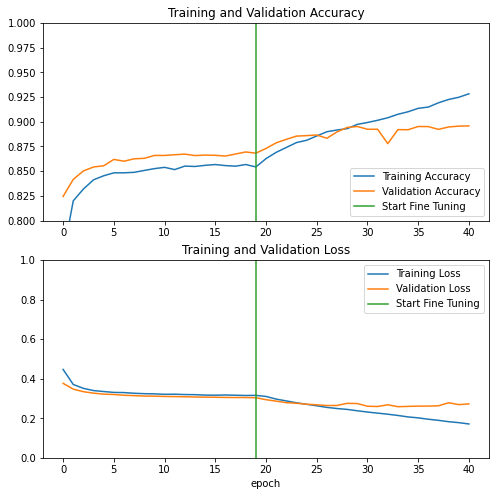

In [22]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [23]:
loss, accuracy = dense_model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

258/258 [==============================] - 25s 98ms/step - loss: 0.2723 - accuracy: 0.8940
Test accuracy : 0.8940075635910034


Found 38391 files belonging to 2 classes.


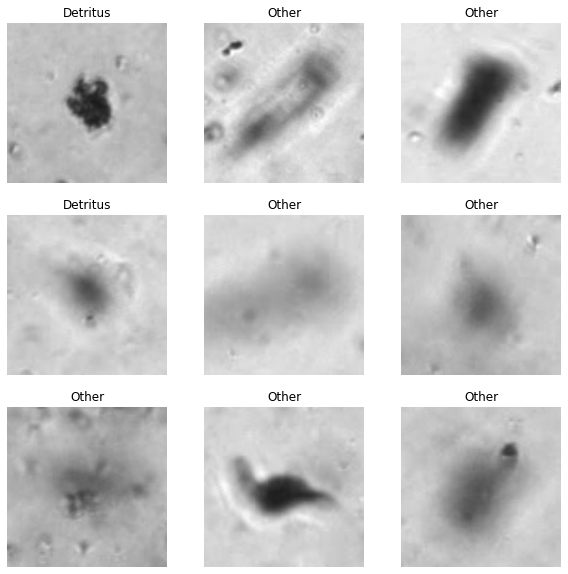

In [24]:

train_dataset = image_dataset_from_directory(train_dir,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE)
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")